<a href="https://colab.research.google.com/github/Rithvika398/MLpractice/blob/master/encoderdecodertrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import numpy as np #matrix math 
import tensorflow as tf #machine learning
#import helpers #for formatting data into batches and generating random sequence data

tf.reset_default_graph() #Clears the default graph stack and resets the global default graph.
sess = tf.InteractiveSession() #initializes a tensorflow session

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:

import numpy as np

def batchfunc(inputs, max_sequence_length=None):
    """
    Args:
        inputs:
            list of sentences (integer lists)
        max_sequence_length:
            integer specifying how large should `max_time` dimension be.
            If None, maximum sequence length would be used
    
    Outputs:
        inputs_time_major:
            input sentences transformed into time-major matrix 
            (shape [max_time, batch_size]) padded with 0s
        sequence_lengths:
            batch-sized list of integers specifying amount of active 
            time steps in each input sequence
    """
    
    sequence_lengths = [len(seq) for seq in inputs]
    batch_size = len(inputs)
    
    if max_sequence_length is None:
        max_sequence_length = max(sequence_lengths)
    
    inputs_batch_major = np.zeros(shape=[batch_size, max_sequence_length], dtype=np.int32) # == PAD
    
    for i, seq in enumerate(inputs):
        for j, element in enumerate(seq):
            inputs_batch_major[i, j] = element

    # [batch_size, max_time] -> [max_time, batch_size]
    inputs_time_major = inputs_batch_major.swapaxes(0, 1)

    return inputs_time_major, sequence_lengths


def random_sequences(length_from, length_to,
                     vocab_lower, vocab_upper,
                     batch_size):
    """ Generates batches of random integer sequences,
        sequence length in [length_from, length_to],
        vocabulary in [vocab_lower, vocab_upper]
    """
    if length_from > length_to:
            raise ValueError('length_from > length_to')

    def random_length():
        if length_from == length_to:
            return length_from
        return np.random.randint(length_from, length_to + 1)
    
    while True:
        yield [
            np.random.randint(low=vocab_lower,
                              high=vocab_upper,
                              size=random_length()).tolist()
            for _ in range(batch_size)
        ]


In [120]:
tf.__version__

'1.12.0'

In [0]:
#First critical thing to decide: vocabulary size.
#Dynamic RNN models can be adapted to different batch sizes 
#and sequence lengths without retraining 
#(e.g. by serializing model parameters and Graph definitions via tf.train.Saver), 
#but changing vocabulary size requires retraining the model.

PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20 #character length

encoder_hidden_units = 20 #num neurons
decoder_hidden_units = encoder_hidden_units * 2 #in original paper, they used same number of neurons for both encoder
#and decoder, but we use twice as many so decoded output is different, the target value is the original input 
#in this example

In [0]:
#input placehodlers
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.string, name='encoder_inputs')
#contains the lengths for each of the sequence in the batch, we will pad so all the same
#if you don't want to pad, check out dynamic memory networks to input variable length sequences
encoder_inputs_length = tf.placeholder(shape=(None,), dtype=tf.string, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.string, name='decoder_targets')

In [0]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

#this thing could get huge in a real world application
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [0]:
from tensorflow.python.ops.rnn_cell import LSTMCell, LSTMStateTuple


In [0]:
encoder_cell = LSTMCell(encoder_hidden_units)


In [0]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, time_major=True)
)

In [128]:
encoder_fw_outputs


<tf.Tensor 'bidirectional_rnn_1/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [129]:
encoder_bw_outputs


<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [130]:
encoder_fw_final_state


LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn_1/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn_1/fw/fw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

In [131]:
encoder_bw_final_state


LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn_1/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn_1/bw/bw/while/Exit_4:0' shape=(?, 20) dtype=float32>)

In [0]:
#Concatenates tensors along one dimension.
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

#letters h and c are commonly used to denote "output value" and "cell state". 
#http://colah.github.io/posts/2015-08-Understanding-LSTMs/ 
#Those tensors represent combined internal state of the cell, and should be passed together. 

encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

#TF Tuple used by LSTM Cells for state_size, zero_state, and output state.
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [0]:
decoder_cell = LSTMCell(decoder_hidden_units)


In [0]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))


In [0]:
decoder_lengths = encoder_inputs_length + 3


In [0]:
#manually specifying since we are going to implement attention details for the decoder in a sec
#weights
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
#bias
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [0]:
#create padded inputs for the decoder from the word embeddings

#were telling the program to test a condition, and trigger an error if the condition is false.
assert EOS == 1 and PAD == 0

eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

#retrieves rows of the params tensor. The behavior is similar to using indexing with arrays in numpy
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [0]:
#manually specifying loop function through time - to get initial cell state and input to RNN
#normally we'd just use dynamic_rnn, but lets get detailed here with raw_rnn

#we define and return these values, no operations occur here
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)  # all False at the initial step
    #end of sentence
    initial_input = eos_step_embedded
    #last time steps cell state
    initial_cell_state = encoder_final_state
    #none
    initial_cell_output = None
    #none
    initial_loop_state = None  # we don't need to pass any additional information
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [0]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [0]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [141]:
decoder_outputs


<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [0]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [0]:
decoder_prediction = tf.argmax(decoder_logits, 2)


In [0]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [0]:
sess.run(tf.global_variables_initializer())


In [146]:
batch_size = 100

batches = random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[2, 2, 3, 3, 5]
[2, 2, 6]
[5, 6, 5, 5, 7, 7]
[3, 4, 3, 4, 6]
[7, 9, 9]
[8, 4, 3]
[3, 2, 6, 3, 6]
[7, 3, 3, 4, 6]
[7, 2, 8, 8, 4, 8, 7, 9]
[9, 8, 9, 8, 7, 7, 8, 4]


In [0]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = batchfunc(batch)
    decoder_targets_, _ = batchfunc(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [0]:
def data():
  l= ['KA 00QD 9818', 'KA 00JE 5855', 'KA 00XR 7470', 'KA 00FB 4471', 'KA 00HD 3350', 'KA 00SQ 6691', 'KA 00KY 1656', 'KA 00OB 6248', 'KA 00DH 3249', 'KA 00NU 6548', 'KA 00TD 1234', 'KA 00HF 9965', 'KA 00UA 2870', 'KA 00AI 7186', 'KA 00KH 1017', 'KA 00SQ 5150', 'KA 00CF 1394', 'KA 00RU 4853', 'KA 00QZ 3878', 'KA 00NK 5513', 'KA 00MK 6173', 'KA 00FE 9960', 'KA 00BM 5125', 'KA 00EF 7988', 'KA 00PS 3872', 'KA 00GL 6489', 'KA 00KI 9047', 'KA 00QJ 1353', 'KA 00SW 4104', 'KA 00JN 7287', 'KA 00RK 9466', 'KA 00TY 1971', 'KA 00HT 2756', 'KA 00TJ 6252', 'KA 00QF 6317', 'KA 00XY 8464', 'KA 00FL 6326', 'KA 00WP 3812', 'KA 00FG 6695', 'KA 00PJ 4524', 'KA 00IS 8354', 'KA 00OM 5336', 'KA 00OH 8873', 'KA 00YD 6503', 'KA 00IP 9105', 'KA 00BU 4907', 'KA 00XH 4337', 'KA 00NL 9638', 'KA 00XY 7673', 'KA 00NL 5628', 'KA 00EZ 6035', 'KA 00TF 6067', 'KA 00IX 6514', 'KA 00VV 2762', 'KA 00NU 3907', 'KA 00KZ 2003', 'KA 00EP 3653', 'KA 00PK 5655', 'KA 00WX 2753', 'KA 00JN 4884', 'KA 00HY 7818', 'KA 00HJ 8002', 'KA 00VN 1024', 'KA 00VS 8590', 'KA 00GX 1006', 'KA 00QY 2869', 'KA 00DU 7176', 'KA 00SE 8715', 'KA 00IW 8819', 'KA 00MI 5216', 'KA 00YN 3990', 'KA 00UU 3933', 'KA 00GV 4125', 'KA 00IL 7715', 'KA 00KG 5668', 'KA 00WA 2558', 'KA 00AL 7440', 'KA 00ZX 2307', 'KA 00KI 2703', 'KA 00VT 8125', 'KA 00PD 3692', 'KA 00GQ 4829', 'KA 00IT 6652', 'KA 00QL 7479', 'KA 00OH 8055', 'KA 00EJ 9298', 'KA 00NC 8814', 'KA 00EN 3528', 'KA 00RZ 4556', 'KA 00PY 4990', 'KA 00AO 1558', 'KA 00QN 9085', 'KA 00BU 1224', 'KA 00TX 3495', 'KA 00WQ 4007', 'KA 00VQ 5644', 'KA 00YE 4571', 'KA 00AH 6746', 'KA 00ZO 2840', 'KA 00RS 9755']
  encoder_inputs_, encoder_input_lengths_=batchfunc(l)
  decoder_targets_, _ = batchfunc(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in l]
  )
  return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }



In [0]:
loss_track = []


In [152]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 0.011218609288334846
  sample 1:
    input     > [4 9 5 0 0 0 0 0]
    predicted > [4 9 5 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [7 8 2 4 6 8 5 5]
    predicted > [7 8 2 4 6 8 5 5 1 0 0]
  sample 3:
    input     > [8 4 7 0 0 0 0 0]
    predicted > [8 4 7 1 0 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.007707471027970314
  sample 1:
    input     > [6 6 3 9 0 0 0 0]
    predicted > [6 6 3 9 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 5 6 8 6 0 0 0]
    predicted > [6 5 6 8 6 1 0 0 0 0 0]
  sample 3:
    input     > [2 2 5 7 3 4 7 2]
    predicted > [2 2 5 7 3 4 7 2 1 0 0]

batch 2000
  minibatch loss: 0.005945148877799511
  sample 1:
    input     > [5 8 6 0 0 0 0 0]
    predicted > [5 8 6 1 0 0 0 0 0 0 0]
  sample 2:
    input     > [7 7 6 6 0 0 0 0]
    predicted > [7 7 6 6 1 0 0 0 0 0 0]
  sample 3:
    input     > [3 5 2 9 8 0 0 0]
    predicted > [3 5 2 9 8 1 0 0 0 0 0]

batch 3000
  minibatch loss: 0.008481381461024284
  sample 1:
    input     

loss 0.1317 after 300100 examples (batch_size=100)


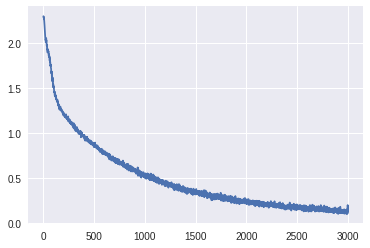

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))

In [157]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = data()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

ValueError: ignored